In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]

In [5]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [6]:
ccrg_excel_fname =  'ccrg and procm genes.xlsx'

In [7]:
# david's reanalysis file
protein_fname = r'Seq46351_report.xlsx'
protein_dpath = os.path.join('1A3','proteomics', 'Davids reanalysis')
protein_fpath = os.path.join(protein_dpath, protein_fname)

In [8]:
genome = 'MIT9313'

In [9]:
genome_df = pd.read_feather(os.path.join('data', f'{genome}.ncbi.gb.feather.gz'))


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [10]:
ccrg_procm_df = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='data')
ccrg_procm_df2 = pd.read_excel(os.path.join('data', ccrg_excel_fname), sheet_name='proc')

In [11]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,PMT_0001,RG24_RS00005",DNA polymerase III subunit beta,,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,PMT_0002,RG24_RS00010",hypothetical protein,,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,PMT_0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,PMT_0004,RG24_RS00020",amidophosphoribosyltransferase,,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,PMT_0005,RG24_RS00025",DNA topoisomerase 4 subunit A,,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [12]:
genome_df = pd.merge(genome_df, ccrg_procm_df, left_on='pmt_id', right_on='Gene', how='left' )

In [13]:
genome_df.loc[genome_df['product'].str.contains('CCRG-2'), 'family'] = 'CCRG-2'

In [14]:
genome_df.loc[genome_df['function'].isin(['Nif11-like leader peptide family natural product precursor', 
                                          'lantipeptide']),
              'family'
             ] = 'ProcA'

In [15]:
genome_df.loc[genome_df['family'] == 'CCRG-1', 'function'].unique()

array([], dtype=object)

In [16]:
ccrg_procm_df.family.value_counts()

ProcA              29
CCRG-2             12
CCRG-1              3
ABC transporter     1
procM               1
Name: family, dtype: int64

In [17]:
genome_df.family.value_counts()

ProcA     35
CCRG-2    15
Name: family, dtype: int64

In [18]:
def find_in_genome(x):
    found = genome_df.loc[(genome_df.left >= x.left-10) & (genome_df.right <= x.right + 10)]
    return found['family'].unique()
ccrg_procm_df2.loc[~ccrg_procm_df2.pmt.isin(genome_df.pmt_id)].apply(find_in_genome, axis=1)


0       [nan]
1     [ProcA]
2     [ProcA]
3     [ProcA]
4     [ProcA]
5     [ProcA]
6     [ProcA]
7     [ProcA]
8     [ProcA]
9     [ProcA]
10    [ProcA]
11    [ProcA]
12    [ProcA]
13    [ProcA]
14    [ProcA]
15    [ProcA]
16    [ProcA]
17    [ProcA]
18    [ProcA]
19    [ProcA]
20    [ProcA]
21    [ProcA]
22    [ProcA]
23    [ProcA]
24    [ProcA]
25    [ProcA]
26    [ProcA]
27    [ProcA]
28    [ProcA]
29    [ProcA]
30      [nan]
dtype: object

In [19]:
ccrg_procm_df.loc[~ccrg_procm_df.Gene.isin(genome_df.pmt_id) & ccrg_procm_df.family.isin(['CCRG-1', 'CCRG-2'])]

,family,Gene
0,CCRG-1,PMT0956
1,CCRG-1,PMT0971
2,CCRG-1,PMT0885
3,CCRG-2,PMT0923
4,CCRG-2,PMT0928
5,CCRG-2,PMT0925
6,CCRG-2,PMT2125
7,CCRG-2,P9313_26651
8,CCRG-2,PMT0238
9,CCRG-2,P9313_26661


In [20]:
# ProcAs.2	s	2	NP_894719	33863159	969887	970183	+	PMT0887	567999
# ProcAs.1	s	1	NP_895437	33863877	1710816	1711142	+	PMT1610	568734
# ProcA4.4	4	4	NP_894754	33863194	1004342	1004653	-	PMT0922	568035
# CCRG1: PMT0971 1049007	1049402
# CCRG1: PMT0885 968520	968768
# CCRG2 1005678	1005340	-	PMT0923
# CCRG2 1010507	1010169	-	PMT0928
# CCRG2 2238151	2237804	-	PMT2125


genome_df.loc[(genome_df.start >= 1049000) & (genome_df.stop <= 1049402), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 968510) & (genome_df.stop <= 968780), 'family'] = 'CCRG-1'
genome_df.loc[(genome_df.start >= 1005320) & (genome_df.stop <= 1005700), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 1010150) & (genome_df.stop <= 1010520), 'family'] = 'CCRG-2'
genome_df.loc[(genome_df.start >= 2237800) & (genome_df.stop <= 2238160), 'family'] = 'CCRG-2'


In [21]:
genome_df.groupby(['family', 'function'])['contig_id', 'Gene'].count()

contig_id  Gene
family function                                                           
CCRG-1 guanylate-binding protein                                   1     0
       hypothetical protein                                        1     0
CCRG-2 CCRG-2 family RiPP                                         12     0
       CCRG-2 family protein                                       3     0
       hypothetical protein                                        3     0
ProcA  Nif11-like leader peptide family natural produc...         34     0
       lantipeptide                                                1     0

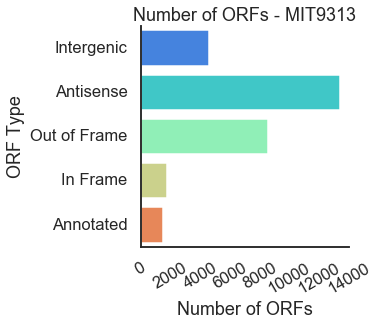

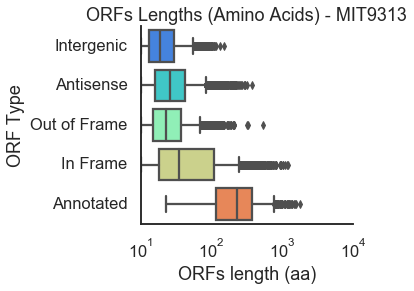

In [22]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}

genome = 'MIT9313'
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.ncbi.sorf.feather.gz'))
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)
    
sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
       order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of ORFs - {genome}')

sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    

In [23]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,...,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence,family,Gene
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,...,MIT9313,"PMT0001,PMT_0001,RG24_RS00005",DNA polymerase III subunit beta,,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,NaN,NaN
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,...,MIT9313,"PMT0002,PMT_0002,RG24_RS00010",hypothetical protein,,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...,NaN,NaN
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,...,MIT9313,"PMT0003,PMT_0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...,NaN,NaN
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,...,MIT9313,"PMT0004,PMT_0004,RG24_RS00020",amidophosphoribosyltransferase,,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,NaN,NaN
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,...,MIT9313,"PMT0005,PMT_0005,RG24_RS00025",DNA topoisomerase 4 subunit A,,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,NaN


In [24]:
df.loc[:,'merge_location'] = df['location']
df.loc[df['location'].isna(), 'merge_location'] = df.loc[df['location'].isna(), 'overlap_location']
df1 = pd.merge(df, genome_df, how='left', left_on='merge_location', right_on='location', suffixes=['', '_overlap'])

In [25]:
df1.loc[df1.otype == 'Annotated'].head().T

,27,34,40,57,70
orfid,ORF29_BX548175.1:12111:12746,ORF36_BX548175.1:15696:17108,ORF42_BX548175.1:18915:19421,ORF59_BX548175.1:26835:27080,ORF74_BX548175.1:34704:35198
contig,BX548175.1,BX548175.1,BX548175.1,BX548175.1,BX548175.1
left,12111,15696,18915,26835,34704
right,12746,17108,19421,27080,35198
start,12111,15696,18915,26835,34704
stop,12746,17108,19421,27080,35198
strand,+,+,+,+,+
aaseq,MQSRSLARELALLVLGQIPERESSRLKTISLESLLQKAFDTLSQHW...,MAGGVTSGSAEGWSKRFEEGLHPVIERFNASISFDITLLQEDLDGS...,MPITALLLSRRSLLIATIAGAFGVYRRPAAAFAATRAEDLDWSLSN...,MTAQLVPDQQIDLRGTPCPINFIRCRLALEGLKDKERLQVDLDRGE...,MAMQLDHDQLHQLLAALAESDIQEFRLEGDDFRLEVRRNIPAPAVV...
len_nn,636,1413,507,246,495
len_aa,211,470,168,81,164


In [26]:
protein_df = pd.read_excel(protein_fpath)

In [27]:
protein_df.Description.head()[0]

'>lcl|ORF9138_BX548175.1:1942594:1942632 unnamed protein product'

In [28]:
protein_df['orfid'] = protein_df['Description'].str.replace(r' unnamed protein product', '').str.replace(r'>lcl\|','')


In [29]:
protein_df.orfid[0]

'ORF9138_BX548175.1:1942594:1942632'

In [30]:
df1.orfid[0]

'ORF1_BX548175.1:78:176'

In [31]:
merge_df = pd.merge(df1, protein_df, how='left', on='orfid', suffixes=['','_p'])

In [32]:
merge_df.head().T

,0,1,2,3,4
orfid,ORF1_BX548175.1:78:176,ORF2_BX548175.1:453:590,ORF3_BX548175.1:669:722,ORF4_BX548175.1:972:1025,ORF5_BX548175.1:1167:1205
contig,BX548175.1,BX548175.1,BX548175.1,BX548175.1,BX548175.1
left,78,453,669,972,1167
right,176,590,722,1025,1205
start,78,453,669,972,1167
stop,176,590,722,1025,1205
strand,+,+,+,+,+
aaseq,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,MVKPWKQRQLMVTALPF,MVLLGVSMLIGVLLLQL,MLFRLLLMFVMY
len_nn,99,138,54,54,39
len_aa,32,45,17,17,12


In [33]:
merge_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Description', '|Log Prob|', 'Best\n|Log Prob|',
       'Best\nscore', 

In [34]:
merge_df.rename(columns={
    '|Log Prob|': 'log_prob', 
    'Best\n|Log Prob|' : 'best log prob',
    'Best\nscore': 'best_score', 
    'Total\nIntensity' : 'total_intensity', 
    '# of\nspectra' : 'num_spectra',
    '# of\nunique peptides'  :'Unique Peptides', 
    '# of mod\npeptides' : 'mod_peptides',
    'Coverage\n%' : 'Coverage',
    "# AA's in\nprotein" : 'AAs',
}, inplace=True)

In [35]:
merge_df['short'] = merge_df.len_aa < 100

In [36]:
(~merge_df.isna()).sum()

orfid              34469
contig             34469
left               34469
right              34469
start              34469
                   ...  
Unique Peptides      980
mod_peptides         980
Coverage             980
AAs                  980
short              34469
Length: 70, dtype: int64

In [37]:
protein_df.shape

(1416, 11)

In [38]:
merge_df['Unique Peptides'] = pd.to_numeric(merge_df['Unique Peptides'])
merge_df['Coverage'] = pd.to_numeric(merge_df['Coverage'])
merge_df['best_score'] = pd.to_numeric(merge_df['best_score'])


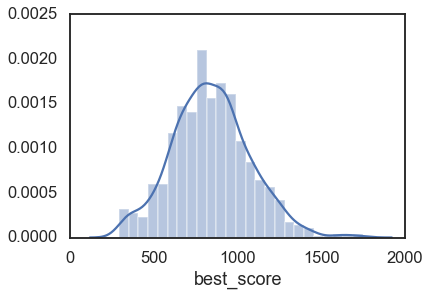

In [39]:
sns.distplot(merge_df.best_score.dropna())

C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


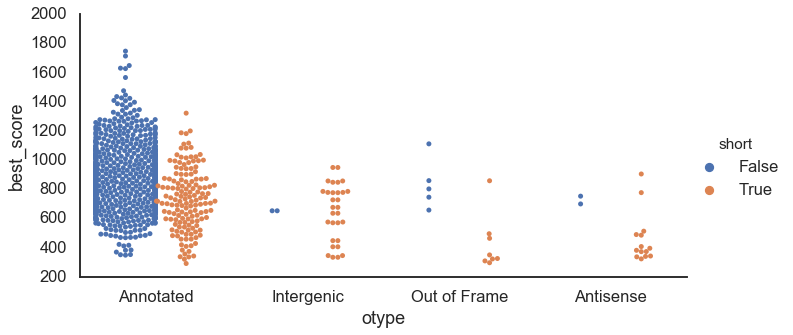

In [40]:
sns.catplot(data=merge_df.dropna(subset=['best_score']), x='otype', y='best_score', aspect=2, 
            kind='swarm', hue='short', split=True)

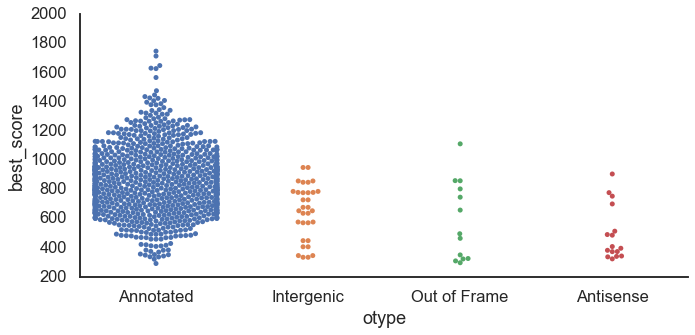

In [41]:
sns.catplot(data=merge_df.dropna(subset=['best_score']), x='otype', y='best_score', aspect=2, 
            kind='swarm', #hue='short', split=True
           )

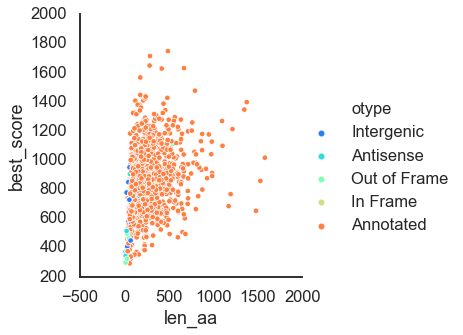

In [42]:
sns.relplot(data=merge_df, y='best_score', x='len_aa', hue='otype', s=30, hue_order=oorder, palette=opalette)

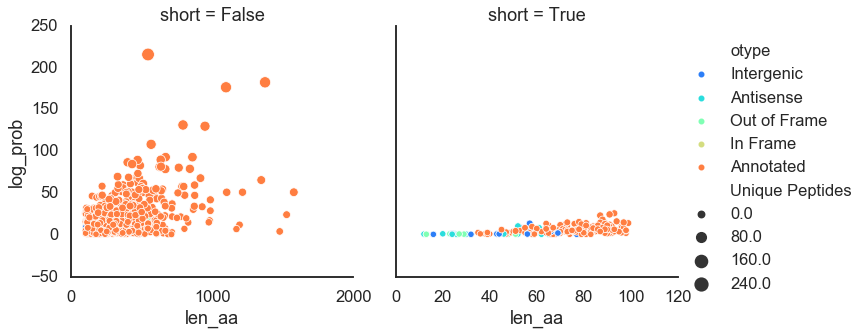

In [43]:
sns.set_context('talk')
g = sns.relplot(data=merge_df, y='log_prob', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='short',
            size='Unique Peptides',# s=30,
           facet_kws=dict(#sharey=False, 
               sharex=False)
           )
g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

In [44]:
merge_df['multiple unique peptides'] = merge_df['Unique Peptides'] > 1
merge_df['has unique peptides'] = merge_df['Unique Peptides'] > 0
merge_df['ms_detected'] = (merge_df['Unique Peptides'] > 1) | (merge_df['best_score'] > 500)

In [45]:
merge_df.shape

(34469, 73)

In [46]:
genome_df.type.value_counts()

CDS           2403
tRNA            44
rRNA             6
ncRNA            3
regulatory       2
tmRNA            1
Name: type, dtype: int64

In [47]:
merge_df['otype'].value_counts()

Antisense       13432
Intergenic       9254
Out of Frame     8544
In Frame         1763
Annotated        1476
Name: otype, dtype: int64

In [48]:
merge_df['ms_detected'].value_counts()

False    33518
True       951
Name: ms_detected, dtype: int64

C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


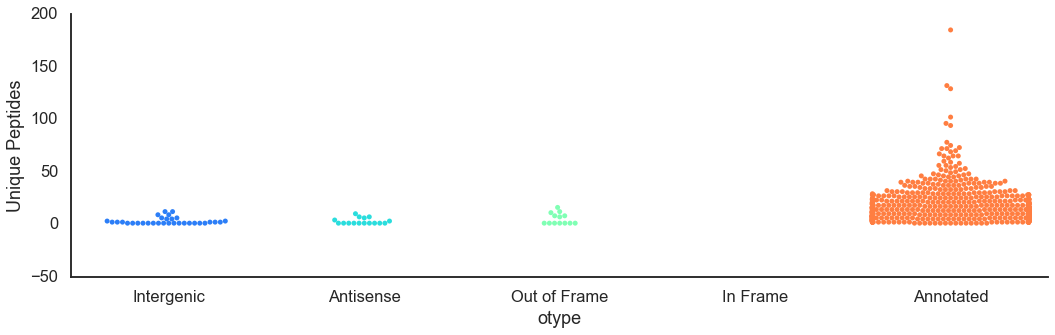

In [49]:
sns.catplot(data=merge_df, x='otype', y='Unique Peptides', aspect=3, kind='swarm', order=oorder, palette=opalette,
           )


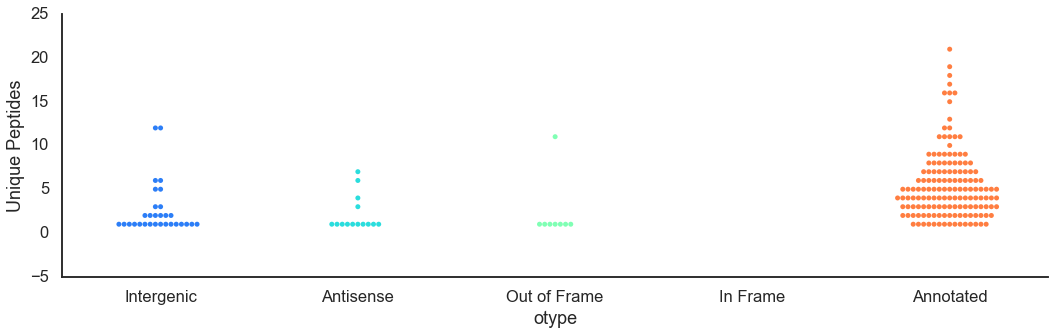

In [50]:
sns.catplot(data=merge_df.loc[merge_df.short], x='otype', y='Unique Peptides', aspect=3, kind='swarm', order=oorder, palette=opalette,
           )


Text(0.5, 1.0, 'protein found < 100 aa')

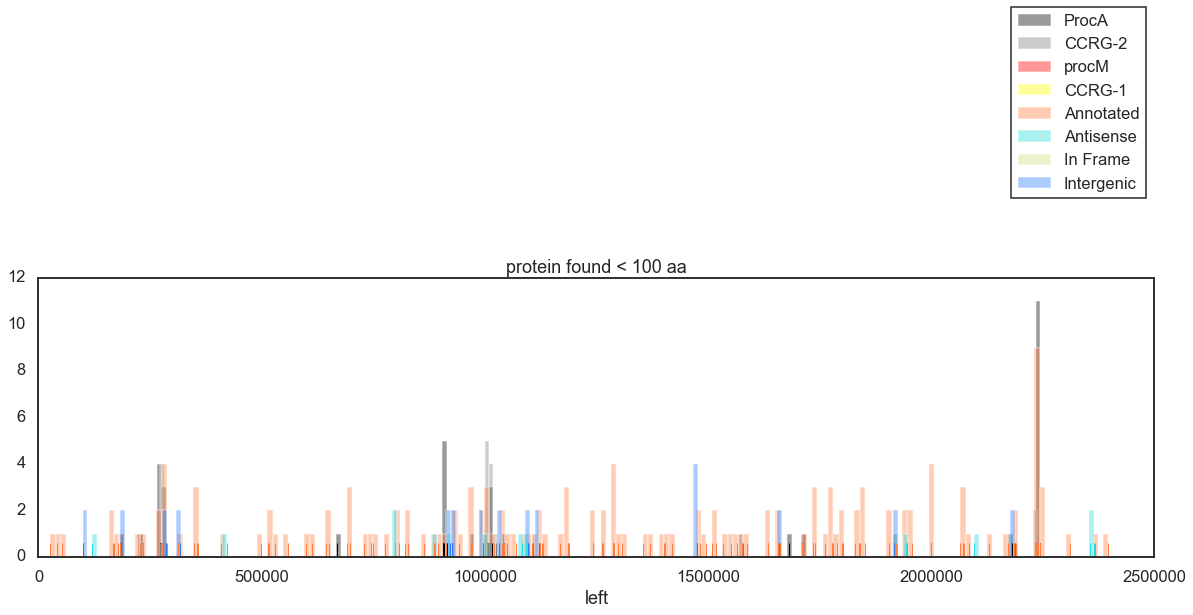

In [51]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          'In Frame', #'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['short'] & merge_df.otype.isin([i])
                         & (~merge_df.best_score.isna()), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(0,2500000)
plt.legend(bbox_to_anchor=(1,2))
plt.title('protein found < 100 aa')

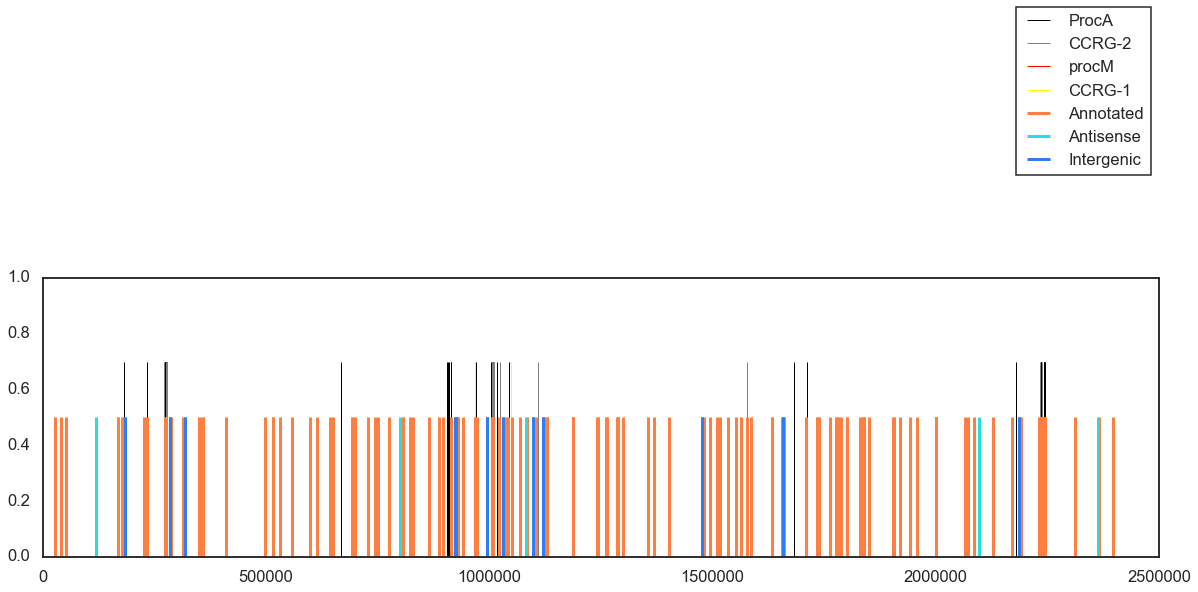

In [52]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.rugplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
           #      bins=200,
             label=i, #rug=True, kde=False, 
                height=0.7,
                linewidths=2,
                ax=ax
                
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.rugplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
           #      bins=2000,
                height=0.5,
                linewidth=3,
                
             label=i, #rug=True, kde=False, 
                ax=ax
           )
    
#plt.xlim(800000,1100000)
plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(200000, 500000)

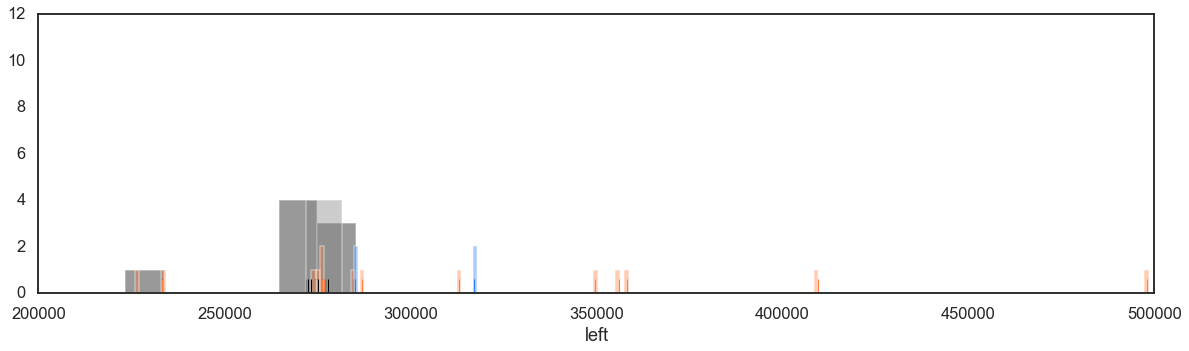

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(200000,500000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

(2100000, 2300000)

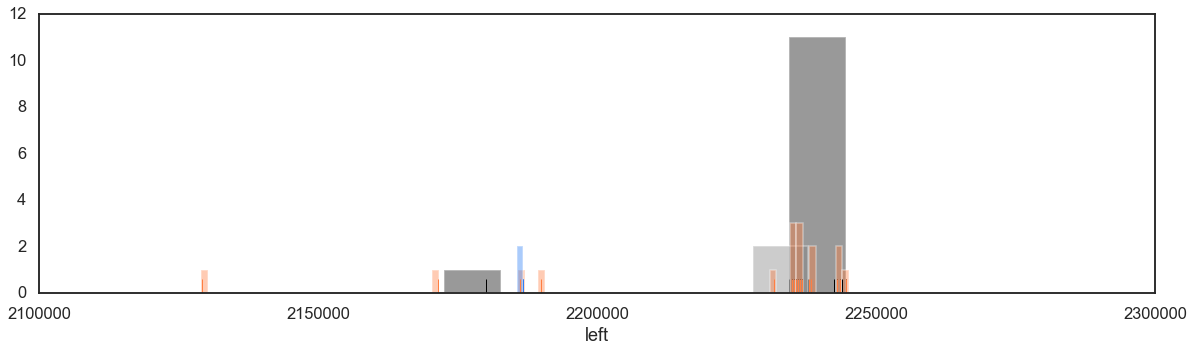

In [54]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
for i in [ 'Annotated', 'Antisense', 
          #'In Frame', 'Out of Frame',
          'Intergenic']:
    sns.distplot(merge_df.loc[merge_df['ms_detected'] & merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'left'
                             ], 
             color=opalette[oorder.index(i)],
                 bins=2000,
             label=i, rug=True, kde=False, ax=ax
           )
    
plt.xlim(2100000,2300000)
#plt.legend(bbox_to_anchor=(1,2))
#plt.title('protein found < 100 aa')

In [55]:
genome_df['family'].unique()

array([nan, 'ProcA', 'CCRG-2', 'CCRG-1'], dtype=object)

(0, 2500000)

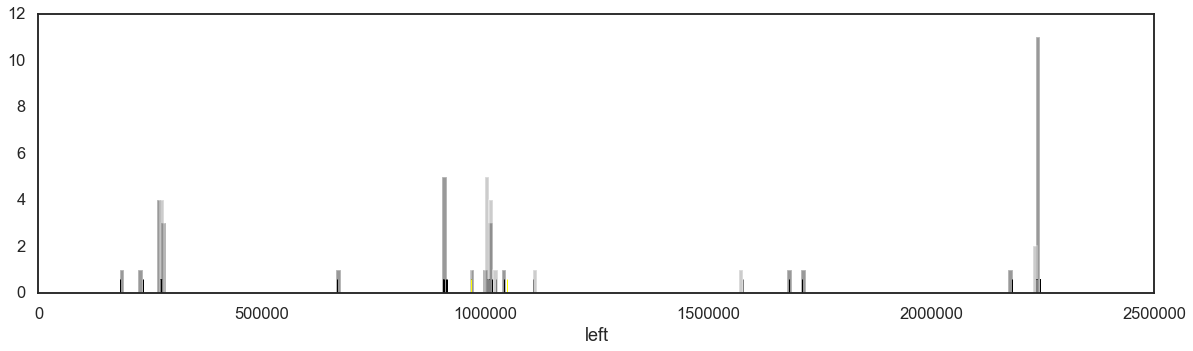

In [56]:
fig, ax = plt.subplots(figsize=(20,5))
for i,j in zip(['ProcA', 'CCRG-2', 'procM', 'CCRG-1'], ['black', 'grey', 'red', 'yellow']):
    sns.distplot(genome_df.loc[genome_df['family'].isin([i]),
                         #& (merge_df.len_aa < 100), 
                               'left'
                             ], 
             color=j,
                 bins=200,
             label=i, rug=True, kde=False, ax=ax
           )
plt.xlim(0,2500000)
#plt.legend()

In [57]:
genome_df.head()

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,...,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence,family,Gene
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,...,MIT9313,"PMT0001,PMT_0001,RG24_RS00005",DNA polymerase III subunit beta,,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,NaN,NaN
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,...,MIT9313,"PMT0002,PMT_0002,RG24_RS00010",hypothetical protein,,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...,NaN,NaN
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,...,MIT9313,"PMT0003,PMT_0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...,NaN,NaN
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,...,MIT9313,"PMT0004,PMT_0004,RG24_RS00020",amidophosphoribosyltransferase,,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,NaN,NaN
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,...,MIT9313,"PMT0005,PMT_0005,RG24_RS00025",DNA topoisomerase 4 subunit A,,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,NaN,NaN


In [58]:
merge_df.loc[~merge_df['best_score'].isna() #& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100), 'otype'].value_counts()


Annotated       149
Intergenic       30
Antisense        14
Out of Frame      8
Name: otype, dtype: int64

In [60]:
merge_df.loc[~merge_df['best_score'].isna()#& merge_df.otype.isin([i])
                         & (merge_df.len_aa < 100)].groupby(['otype', 'family'])['Unique Peptides'].count()
             #,'family'].value_counts()


otype         family
Annotated     CCRG-2     2
              ProcA     17
Out of Frame  ProcA      1
Name: Unique Peptides, dtype: int64

In [64]:
found_sorf_df = pd.read_pickle('found_sorf_ISME16.pkl.gz')

In [65]:
mdf = merge_df.dropna(subset=['best_score'])

In [66]:
found_orfids = found_sorf_df.orfid

Text(0.5, 1.0, 'newly found peptides')

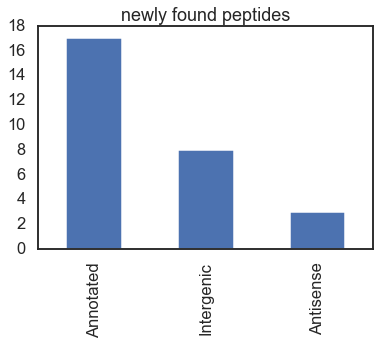

In [81]:
mdf.loc[~mdf.orfid.isin(found_orfids) & mdf.short & mdf.ms_detected].drop_duplicates().otype.value_counts().plot(kind='bar')
plt.title('newly found peptides')

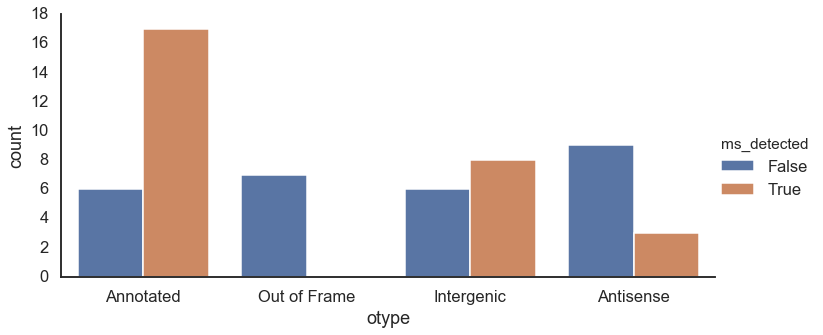

In [80]:
sns.catplot(data=mdf.loc[~mdf.orfid.isin(found_orfids) & mdf.short].drop_duplicates(),
            x='otype', kind='count', hue='ms_detected',aspect=2)


In [69]:
found_sorf_df.loc[~found_sorf_df.orfid.isin(mdf.orfid)].otype.value_counts()

In Frame     22
Annotated     5
Name: otype, dtype: int64

In [70]:
mdf['is_found_technion'] = mdf.orfid.isin(found_orfids)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


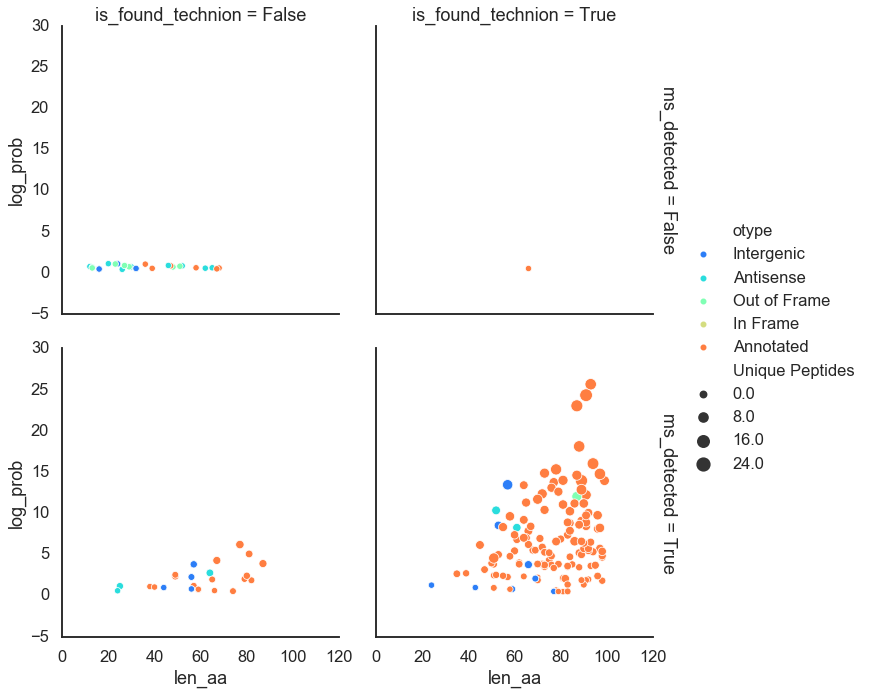

In [71]:
sns.set_context('talk')
g = sns.relplot(data=mdf.loc[mdf.short], y='log_prob', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='is_found_technion', row='ms_detected',
            size='Unique Peptides',# s=30,
           facet_kws=dict(margin_titles=True),
 #          facet_kws=dict(#sharey=False, 
 #              sharex=False)
           )
#g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

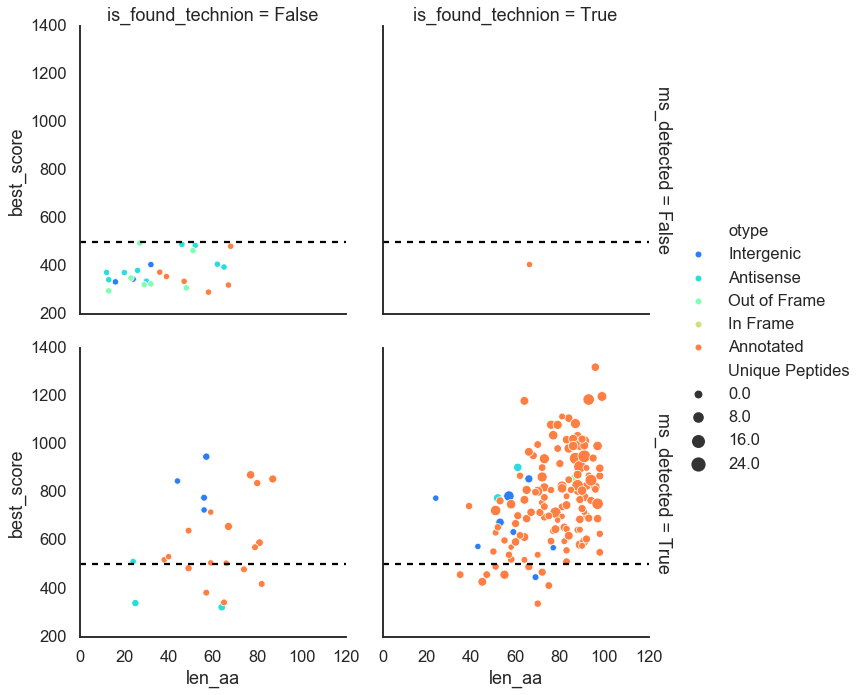

In [79]:
sns.set_context('talk')
g = sns.relplot(data=mdf.loc[mdf.short].drop_duplicates(), y='best_score', x='len_aa', hue='otype',  hue_order=oorder, 
            palette=opalette, col='is_found_technion', row='ms_detected',
            size='Unique Peptides',# s=30,
           facet_kws=dict(margin_titles=True),
                #sharey=False, 
 #              sharex=False)
           )
for ax in g.axes.flat:
    ax.axhline(500, color='black', ls='--')
#g.axes.flat[0].set_xticks([0,1000,2000]) # set new labels

In [73]:
mdf.loc[mdf.ms_detected & mdf.is_found_technion, 'status']  = 'Detected'
mdf.loc[mdf.ms_detected & ~mdf.is_found_technion, 'status']  = 'Detected, new'
mdf.loc[~mdf.ms_detected , 'status']  = 'Not Detected'

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


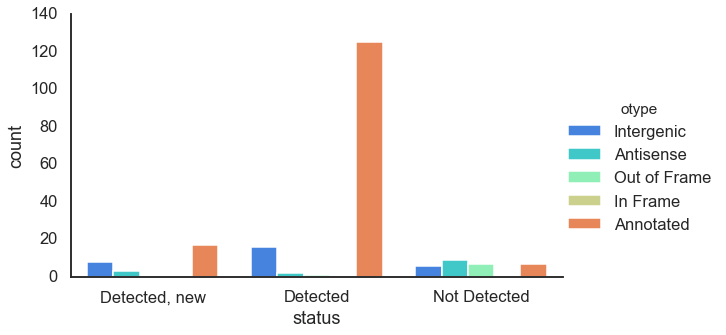

In [78]:
sns.catplot(data=mdf.loc[mdf.short].drop_duplicates(), hue='otype', kind='count', x='status', 
            hue_order=oorder, palette=opalette, aspect=1.6
            
           )

In [75]:
mdf.loc[mdf.status.isin(['Not Detected']) & mdf.short,
        [
        'otype',
        #'product', 
            'Description',
         #'log_prob', 'best log prob',
       'best_score', #'total_intensity', 'num_spectra', 'Unique Peptides',
       #'mod_peptides', 'Coverage', 'AAs',
        #'is_found_before',
       ]].sort_values('best_score', ascending=False).drop_duplicates()

,otype,Description,best_score
33008,Out of Frame,>lcl|ORF29969_BX548175.1:667453:667370 unnamed...,494.7
27582,Antisense,>lcl|ORF25051_BX548175.1:421403:421263 unnamed...,489.1
13584,Antisense,>lcl|ORF12307_BX548175.1:995366:995524 unnamed...,484.9
10442,Annotated,>lcl|ORF9428_BX548175.1:2073463:2073669 unname...,481.7
30846,Out of Frame,>lcl|ORF28093_BX548175.1:1472029:1471874 unnam...,463.3
14102,Annotated,>lcl|ORF12709_BX548175.1:1167725:1167925 unnam...,408.0
11019,Antisense,>lcl|ORF9973_BX548175.1:2355340:2355528 unname...,406.9
22523,Intergenic,>lcl|ORF20436_BX548175.1:99408:99310 unnamed p...,405.3
7825,Antisense,>lcl|ORF7067_BX548175.1:920434:920631 unnamed ...,395.1
17938,Antisense,>lcl|ORF16323_BX548175.1:1923888:1923808 unnam...,381.1


In [76]:
mdf.columns


Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Description', 'log_prob', 'best log prob',
       'best_score', 'total

In [77]:
980*0.1

98.0

In [82]:
mdf = mdf.drop_duplicates()

In [83]:
mdf.loc[mdf.short & mdf.ms_detected].to_pickle('found_sorf_ISME16_David.pkl.gz')